<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/release/landlab_header.png"></a>

# Introduction to Landlab: Grids and simple 2D models

This tutorial will introduce you to the basics of Landlab grids. By the end, you will have a basic understanding of the following:

- The elements that comprise a landlab grid
- The numbering of grid elements 
- How to instantiate different types and sizes of landlab grids
- How to attach fields to grids and set boundary conditions
- How to perform basic calculations across the grid

The tutorial concludes with an (optional / time-permitting) example of how we can rapidly construct a simple, two-dimensional diffusion model on a Landlab raster grid. 

Time-permitting, we may also learn how to instantiate a component that will replicate the diffusion model for us.

## What types of problems can Landlab solve?

Landlab is great for a variety of earth science problems that have one thing in common: routing a flow across a grid. In today's clinic, we'll see how Landlab handles the gradient calculations that are central to driving many earth (or planetary!) surface processes.

<img src="./media/flow_examples.png"
     width = "600"
     height = auto />
     
     
     



## What you need to know about Landlab grids

Landlab model grids are 2D data structures that represent the model domain. A few things to know about grid management:

- Grids are Python <i>objects</i>
- Grids use flat arrays
- Grids are comprised of <i>elements</i> such as nodes and links (see Figure)
- Grids are generated from the user-specified geometry of nodes
- Data fields can be attached to grid elements
- Methods are functions to perform operations on the data fields
- There are regular (raster, radial, and hexgonal) and irregular (Voronoi-Delauney) grid types
- Grids have some built-in numerical functions, such as gradient and divergence


<img src="./media/Grids1.png"/>

**Figure** Geometry and topology of grid elements on various Landlab grids ([Hobley et al. 2017](https://esurf.copernicus.org/articles/5/21/2017/))

-- [Interactive sketchbook](https://landlab.github.io/grid-sketchbook/)

### (a) Explore the Landlab grids

First let's visualize the types of grids that Landlab supports. The most common is the `RasterModelGrid`, but different grid types are useful for different applications. We'll start by importing a couple different grid libraries, plus some tools that will help us visualize the grids.

In [1]:
# import libraries
from landlab import RasterModelGrid, HexModelGrid
from landlab.plot.graph import plot_graph
from landlab import imshow_grid

`RasterModelGrid` and `HexModelGrid` are both Python <i>classes</i>, and the instances we create of those classes will be our grid <i>objects</i>. For starters, we'll get some basic information on `RasterModelGrid`. Then we'll create an instance of the class `RasterModelGrid` with 3 rows, 4 columns, and 10-unit grid spacing. We'll call our grid object `rmg`.

In [2]:
# get info on RasterModelGrid
?RasterModelGrid

In [3]:
# create a grid instance
rmg = RasterModelGrid((3, 4), 10)

Now let's start to visualize how the nodes, links, and cells of our grid are numbered. Because grid information is stored in flat arrays, understanding the numbering order is critical to indexing the grid. For this visualization we'll use the `plot_graph` library. `plot_graph` takes two arguments: the first is the grid that we want to look at (`rmg`), and the second is the grid element that we want to inspect. In this first example, we'll inspect the nodes.

<Axes: xlabel='x', ylabel='y'>

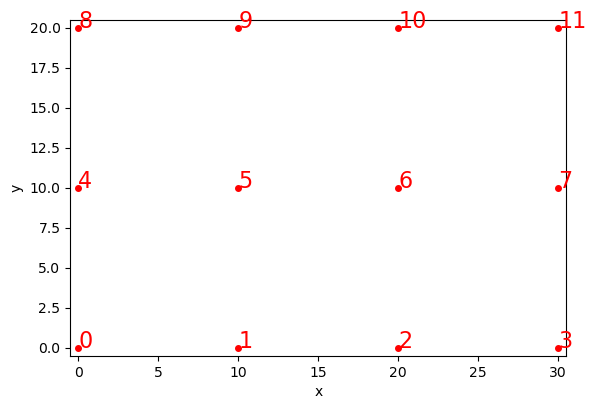

In [4]:
# visualize nodes
plot_graph(rmg, at="node")

Your turn: Use `plot_graph` to visualize the `link`s and `cell`s of our grid, `rmg`. How many links does `rmg` have? How many cells?

In [5]:
# visualize links

<Axes: xlabel='x', ylabel='y'>

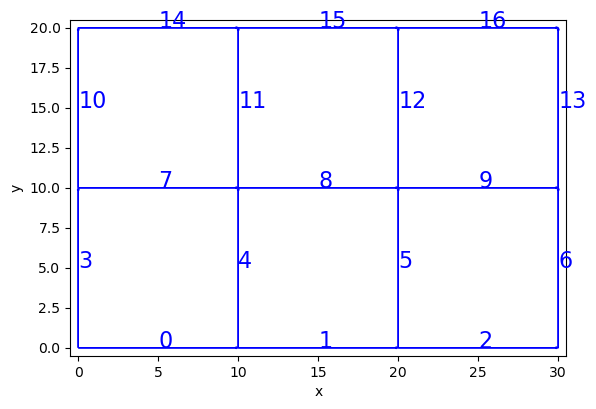

In [6]:
plot_graph(rmg, at="link")

In [7]:
# visualize cells

<Axes: xlabel='x', ylabel='y'>

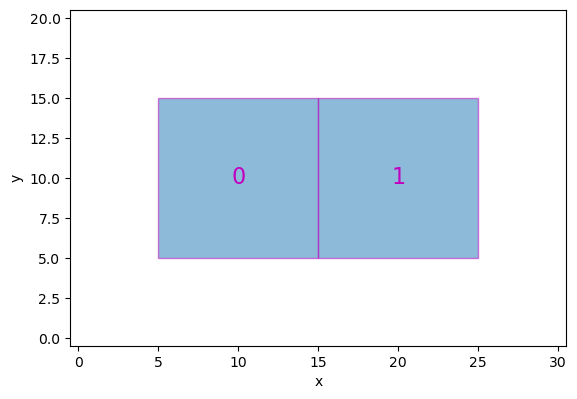

In [8]:
plot_graph(rmg, at="cell")

Neat! We'll return to our raster grid momentarily, but let's quickly look at the `HexModelGrid`, just for fun. Notice that when using `HexModelGrid`, the "column" argument specifies the number of nodes along the bottom of the grid.

In [9]:
# create hexagonal grid
hmg = HexModelGrid((3, 4), 10)

In [10]:
# plot nodes

<Axes: xlabel='x', ylabel='y'>

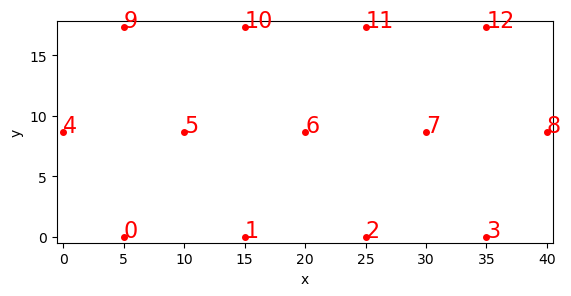

In [11]:
plot_graph(hmg, at="node")

In [12]:
# plot links

<Axes: xlabel='x', ylabel='y'>

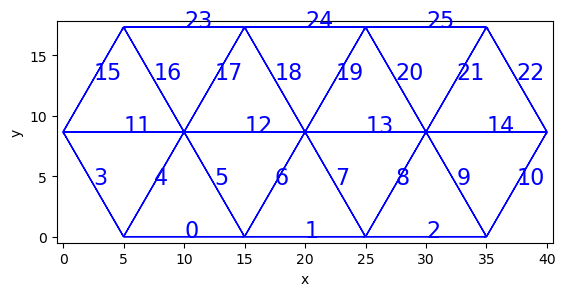

In [13]:
plot_graph(hmg, at="link")

In [14]:
# plot cells

<Axes: xlabel='x', ylabel='y'>

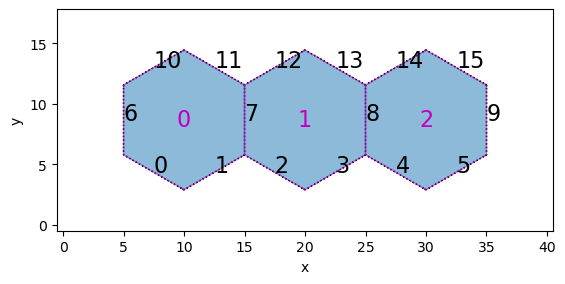

In [15]:
plot_graph(hmg, at="cell,face")

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# plot nodes
plot_graph(hmg, at="node")

# plot links
plot_graph(hmg, at="link")

# plot cells
plot_graph(hmg, at="cell, face")
```
    
</details>

Great. We'll now return to `rmg` for the remaining exercises. First, let's get some basic information on the gird. For example, you can imagine that if you had a grid with many nodes (thousands! millions!), the `plot_graph` tool would cease to be very helpful. Instead, we can use some of Landlab's built-in grid fucntions to call information on the grid. We'll start by using a method to find the total number of nodes in `rmg`.

In [16]:
# find number of nodes
rmg.number_of_nodes

12

`number_of_nodes` tells us that `rmg` has 12 nodes, and we can easily verify this visually. In the cell below, type a line of code to find the `number_of_core_nodes`.

In [17]:
# find number of core nodes here
rmg.number_of_core_nodes

2

You should find that there are two core nodes. Again, when working with such a small grid, we can visually verify this. We can also easily use `plot_graph` to find the index values of those core nodes. But what if we had a very large grid? Then we would want a way to get the indices of core nodes as an array. We can do this with the following line of code. It tells us that the core nodes of the grid have index values 5 and 6.

In [18]:
# get index values of core nodes
rmg.core_nodes

array([5, 6])

### (b) Add fields and manipulate boundaries (but first, a quick interlude about boundary and core nodes)

At this point, we've alluded to there being more than one type of grid node. Indeed, there are two types: "boundary" and "core" nodes. What's up with these? Very simply, boundary nodes form the perimeter of the grid. They can be given boundary conditions, such as constant sediment flux, or constant base-level lowering. They can also be set to be "open" or "closed." This will make more sense as we move through this next section, in which we start to attach values to grid elements. 

Finally, we're ready to start adding data to our grid. The first thing we'll do is create a field that holds values of topographic elevation (in a geological framework, this would be like bedrock elevation). We'll start by making elevation 0 everywhere, and later we can add other values. We want the information about elevation to be held on the grid nodes (as opposed to on links or cells.)

In [19]:
# create elevation field filled with zeros
z = rmg.add_zeros("topographic__elevation", at="node", clobber=True)

We have a field! Wahooooo! Recall that all grid information is held as flat arrays. That means `z` is a 1D array. And because a `z` was added at every node on `rmg`, the `z` array should have the same length and numbering as `rmg` nodes. Let's verify both below.

In [20]:
# print the data type of "z"
type(z)

numpy.ndarray

In [21]:
# print the length of "z"
len(z)

12

We can now use standard Python indexing to set values just on the core nodes. Let's give the first core node a value of 5. Then you set a value of 3.6 for the next core node. Print out the array to see how it looks.

In [22]:
# set elevation of first core node

# set elevation for next core node

# print array

In [23]:
z[rmg.core_nodes[0]] = 5.0
z[rmg.core_nodes[1]] = 3.6
print(z)

[ 0.   0.   0.   0.   0.   5.   3.6  0.   0.   0.   0.   0. ]


<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# set elevation of first core node
z[rmg.core_nodes[0]] = 5.0

# set elevation for next core node
z[rmg.core_nodes[1]] = 3.6

# print array
print(z)
```

</details>

In addition to printing the array, we can also use the `imshow_grid` library that we imported at the top of this notebook to visulize these grid values. `imshow_grid` takes two arguments: first, the name of the grid that we're working with, and second, the name of the field that we're trying to visualize.

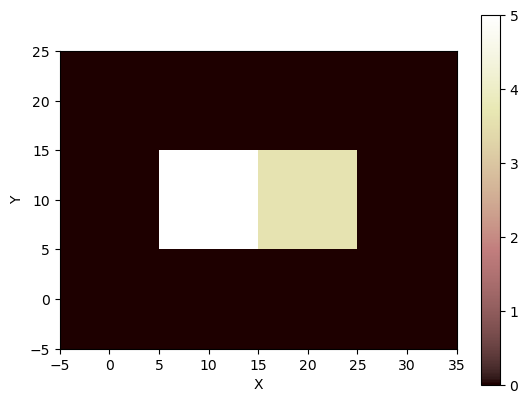

In [24]:
# visualize topographic elevation field
imshow_grid(rmg, "topographic__elevation")

Great, we now have elevation values associated with each node. Each node can hold as many field values as you like - for example, try adding another field of zeros, called `soil__depth`, to the grid nodes. Assign these values to an array called `soil`. You can get a list of all the fields associated with a grid by using the method `at_node.keys`.

In [25]:
# add soil depth field here

In [26]:
rmg.add_zeros("soil__depth", at="node")

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# add soil depth field here
rmg.add_zeros("soil__depth", at="node")
```

</details>


In [27]:
# see all fields associated with grid
rmg.at_node.keys()

['topographic__elevation', 'soil__depth']

Now that our landscape has a topographic gradient, sediment can start to move across it. This means we need to decide what's going to happen at the edges of our grid. Will sediment be able to cross those boundaries, or not? Landlab makes this easy. Below, we set the top and bottom boundaries to be open and the left and right boundaries to be closed using the grid function `set_closed_boundaries_at_grid_edges`. The order of arguments to this function is east, north, west, south.

In [28]:
# close boundaries
rmg.set_closed_boundaries_at_grid_edges(True, False, True, False)

### (c) Gradients

Many earth science problems depend on spatial gradients on the landscape. Let's say we want to find the topographic gradient between each pair of adjacent nodes on `rmg`. This is information that is associated not with the grid nodes, but instead with grid <b>links</b> that connect nodes. Let's take a closer look at links.

##### What are links?

For each pair of adjacent nodes in a Landlab grid, there is a corresponding **link**. Links are directed line segments whose endpoints are the coordinates of the nodes. A link can be illustrated like this:

    o---->o

Here, each o represents a node, and the arrow is the link. A "vertical" link looks like this:

    o
    ^
    |
    |
    o

The tip of the arrow is known as the **link head**; the base of the arrow is known as the **link tail**. By default, links always "point" within the upper-right half-plane.

With this definition of links in mind, we can sketch our grid, `rmg`, like so, with the ID numbers of the nodes shown by the numbers:


    8 ----> 9 ----> 10----> 11
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    4 ----> 5 ----> 6 ----> 7
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    0 ----> 1 ----> 2 ----> 3


If we label each node with its elevation (`z`) value, it looks like this:


    0 ----> 0 ----> 0 ----> 0
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    0 ---->5.0---->3.6----> 0
    ^       ^       ^       ^
    |       |       |       |
    |       |       |       |
    0 ----> 0 ----> 0 ----> 0
    

Let's plot the layout of the nodes and links of our grid object again:

<Axes: xlabel='x', ylabel='y'>

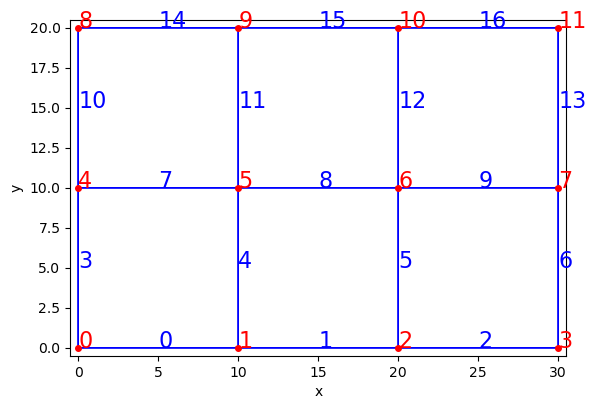

In [29]:
# check out the nodes and links
plot_graph(rmg, at="node, link")

To calculate the flux of particles, we need to know the gradient between two adjacent nodes. We can do this easily using Landlab's built-in grid function, `calc_grad_at_link`.

In [30]:
# create a gradient array
dzdx = rmg.calc_grad_at_link(z)

# print it out
print(dzdx)

[ 0.    0.    0.    0.    0.5   0.36  0.    0.5  -0.14 -0.36  0.   -0.5
 -0.36  0.    0.    0.    0.  ]


Here's a crude graphical representation of gradient array:


    o ---0--> o ---0--> o ---0--> o
    ^         ^         ^         ^
    0       -0.5      -0.36       0
    |         |         |         |
    o  +0.5 > o -0.14 > o -0.36 > o
    ^         ^         ^         ^
    0       +0.5      +0.36       0
    |         |         |         |
    o ---0--> o ---0--> 0 ---0--> 0

Links are listed in order by the $(x, y)$ coordinates of their midpoints. The ID numbering scheme for our links looks like this:


    o --14--> o --15--> o --16--> o
    ^         ^         ^         ^
    10       11        12        13
    |         |         |         |
    o ---7--> o ---8--> o ---9--> o
    ^         ^         ^         ^
    3         4         5         6
    |         |         |         |
    o ---0--> o ---1--> 0 ---2--> 0

Let's explore how the geometry and the values in the ID array of gradients correspond. Here are the gradients  associated with the first three horizontal links along the bottom edge of the grid:

In [31]:
# check out values associated with first three horizontal links
dzdx[0:3]

array([ 0.,  0.,  0.])

Next come four vertical links that connect the bottom to the middle rows of nodes. Two of these values are positive. Which way is sediment moving, relative to the directionality of the links?

In [32]:
# now check out values associated with first four vertical links
dzdx[3:7]

array([ 0.  ,  0.5 ,  0.36,  0.  ])

As you can see, you can recover the values associated with links through basic Python index. However, this can become tedious. An alternative way to inspect link-based values in a raster grid is to use the `horizontal_links` and `vertical_links` grid attributes:

In [33]:
# get all of the values of horizontal links
dzdx[rmg.horizontal_links]

array([ 0.  ,  0.  ,  0.  ,  0.5 , -0.14, -0.36,  0.  ,  0.  ,  0.  ])

In [34]:
# get all of the values of vertical links

In [35]:
dzdx[rmg.vertical_links]

array([ 0.  ,  0.5 ,  0.36,  0.  ,  0.  , -0.5 , -0.36,  0.  ])

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# get all of the values of vertical links
dzdx[rmg.vertical_links]
```

</details>


### (d) Sediment diffusion

Finally, we can put together the basics of Landlab with some geomorphic soil transport laws to write a quick-n-easy diffusion model! First, we'll need to tackle a tiny bit of math.

<img src="./media/fault_scarp.png"
     width = "600"
     height = auto />

This example will use a finite-volume numerical solution to the 2D diffusion equation. The 2D diffusion equation in this case is derived as follows. Continuity of mass states that:

$\frac{\partial z}{\partial t} = -\nabla \cdot \mathbf{q}_s$,

where $z$ is elevation, $t$ is time, the vector $\mathbf{q}_s$ is the volumetric soil transport rate per unit width, and $\nabla$ is the divergence operator (here in two dimensions). (Note that we have omitted a porosity factor here; its effect will be subsumed in the transport coefficient). The sediment flux vector depends on the slope gradient:

$\mathbf{q}_s = -D \nabla z$,

where $D$ is a transport-rate coefficient---sometimes called *hillslope diffusivity*---with dimensions of length squared per time. Combining the two, we have a classical 2D diffusion equation:

$\frac{\partial z}{\partial t} = D \nabla^2 z$.

Let's create a new `RasterModelGrid`, somewhat larger than the one used in previous examples. This will allow us to see the movement of sediment more clearly. Try making a grid, called `mg`, with dimensions 25 x 25 and spacing of 10.

In [36]:
# create your grid here

In [37]:
mg = RasterModelGrid((25, 25), 10)

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# create your grid here
mg = RasterModelGrid((25, 25), 10)
```

</details>

We need to define our hillslope diffusivity, `D`, and choose a timestep. For the timestep we use a [Courant–Friedrichs–Lewy condition](https://en.wikipedia.org/wiki/Courant–Friedrichs–Lewy_condition) of $C_{cfl}=0.2$. This will keep our solution numerically stable. 

$C_{cfl} = \frac{\Delta t D}{\Delta x^2} = 0.2$

We can call the x spacing of our grid using `mg.dx`.

In [38]:
# transport coefficient, aka hillslope diffusivity
D = 0.01

# calculate timestep
dt = 0.2 * mg.dx**2 / D

# print timestep
print(dt)

2000.0


Now we need to add an elevation field. Create a field of zeros called `topographic__elevation` and attach it to the grid nodes. Save it to an array called `elev`.

In [39]:
# create elevation field here

In [40]:
elev = mg.add_zeros("topographic__elevation", at="node")

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# create elevation field here
elev = mg.add_zeros("topographic__elevation", at="node")
```

</details>

Now we need to introduce some topographic variability onto our landscape. We can do this by elevating the upper half of our grid. We can do this by indexing our elevation array (`elev`) to raise all of the nodes whose y-value (`y_of_node`) exceeds a given value, like so:

In [41]:
# elevate upper half of grid
elev[mg.y_of_node > 120] += 10

Check out what the landscape looks like using `imshow_grid`.

In [42]:
# display landscape

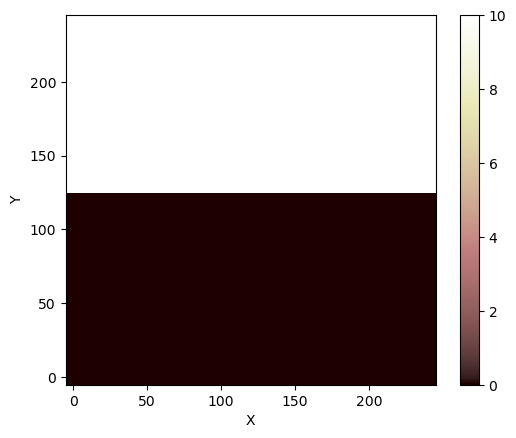

In [43]:
imshow_grid(mg, "topographic__elevation")

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# display landscape
imshow_grid(mg, "topographic__elevation")
```

</details>


Now we need to create a field that can track our sediment flux between nodes. Since this is a value that exists <i>between nodes</i>, it will be stored on <i>links</i>. Create a field called `sediment__flux` that is associated with grid `link`s, and save it to an array called `qs`.

In [44]:
# create sediment flux field here

In [45]:
qs = mg.add_zeros("sediment__flux", at="link")

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# create sediment flux field here
qs = mg.add_zeros("sediment__flux", at="link")
```

</details>


Let's close the left and right boundaries, similar to what we did in part <b>(b)</b> above.

In [46]:
# close left and right boundaries

In [47]:
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# close left and right boundaries
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
```

</details>


Finally, we want to evolve our landscape for 50000 years. Since our timestep is 2000 years, this means we'll run a for loop for 25 iterations. The steps are as follows:

- calculate a topographic gradient
- multiply that gradient by the hillslope diffusivity
- calculate sediment flux divergence (check calc_flux_div_at_node function of raster model grid)
- update the landscape
- repeat

In [48]:
# write for loop to evolve landscape

In [49]:
for i in range(25):
    g = mg.calc_grad_at_link(elev)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    elev[mg.core_nodes] += dzdt[mg.core_nodes] * dt

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# write for loop to evolve landscape
for i in range(25):
    g = mg.calc_grad_at_link(elev)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    elev[mg.core_nodes] += dzdt[mg.core_nodes] * dt
```

</details>


Check out your final landscape once more using `imshow_grid`

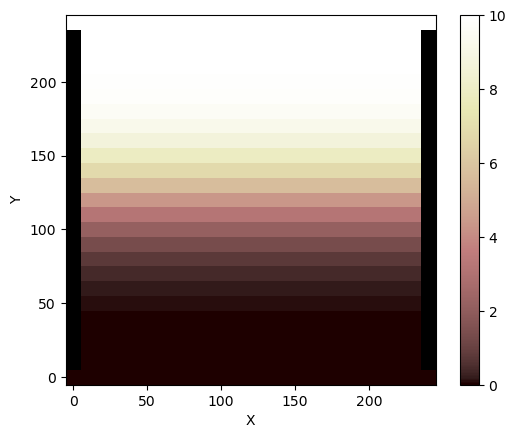

In [50]:
# display your final landscape
imshow_grid(mg, "topographic__elevation")

Well done!

### (e) Sediment diffusion with a Landlab component

Finally, we'll take a look at how Landlab components can simplify model creation even further.

Recall that in the `for` loop above, you managed to create a working sediment diffusion model with just five lines of code. However, before running the `for` loop you had to independently create the fields and parameters involved in the diffusion problem. <b>This is where Landlab's component library comes in handy!</b>

The Landlab component library is composed of individual, interoperable code packages ("components") that each represent a single Earth surface process. Examples of components include flow routing algorithms, a variety of fluvial processes, and yes, soil processes! 

In this final part of our clinic, we'll make use of Landlab's `LinearDiffuser` component to replicate our diffused fault scarp landscape. This time, we'll let the component do more of the work of field and parameter creation for us.

Start by importing the component `LinearDiffuser` from `landlab.components`.

In [51]:
from landlab.components import LinearDiffuser

Great, we've imported a component which is going to help us build a diffusion model. Before we really start to use this component, though, we want to get some basic information on how it works. This information is stored in component "properties." One such property is `input_var_names`. Call any property using the syntax `ComponentName.property_name`.

In [52]:
# check out input variable names
LinearDiffuser.input_var_names

('topographic__elevation',)

This tells us that the only input variable required by this component is an elevation field, so we'll need to create that ourselves. 

Other standard properties are `output_var_names` and `optional_var_names`; pass an input or output name to `var_loc`, `var_type`, `var_units`, and `var_definition` to get the centering ('node', 'link', etc), array dtype (float, int), units (meters, etc) and a descriptive string, respectively. `var_help` will give you a lot of this information at once:

In [53]:
# ask for info related to the input variable 'topographic__elevation'
LinearDiffuser.var_help("topographic__elevation")

name: topographic__elevation
description:
  Land surface topographic elevation
units: m
unit agnostic: True
at: node
intent: inout


If we want to see the complete documentation, we can also access this information using `?`, similar to how we accessed information from `RasterModelGrid` in part <b>(a) (Explore the Landlab grids)</b>.

In [54]:
# recall the question mark notation used to access documentation in Landlab
?LinearDiffuser

Note we haven't needed to <i>instantiate</i> the component in order to access any of this information. Instantiation occurs when we create a unique instance of the component with specific variables and parameter values (just like how we created <i>instances</i> of `RasterModelGrid` above with unique names, dimensions, and grid spacing.) Don't worry if this is confusing right now - it will make sense momentarily. 

Since we know `LinearDiffuser` requires a topographic elevation field in order to be instantiated, we need to create that field. Recall that `topographic__elevation` is tied to grid nodes, so we actually need to create a grid instance, and add the `topographic__elevation` field onto the grid. This is just like the steps we took in part <b>(d)</b> <b>(Sediment diffusion)</b> of this tutorial.

Create a new grid instance for the `LinearDiffuser` component to run on. Give your new grid a new name (perhaps `new_grid`?), but give it the same dimensions as `mg` (25 x 25, with 10m spacing).

In [55]:
# create a new grid here

In [56]:
new_grid = RasterModelGrid((25, 25), 10)

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# create a new grid here
new_grid = RasterModelGrid((25, 25), 10)
```

</details>


Great, we now have a grid on which we can implement our diffusion component. Recall, however, our diffusion equation from above:

$$\frac{\partial z}{\partial t} = D \nabla^2 z$$.

As before, we need some topographic variation in order to drive diffusion. We'll still need to add our `topographic__elevation` field manually, and we'll need to create a "fault" on the grid by elevating half of the nodes. Let's do this now, following the format we used in <b>(d) (Sediment diffusion)</b>.

Hint: in <b>(d) (Sediment diffusion)</b>, we saved our elevation data to an array named `elev`. Be sure to give your elevation array a different name here - perhaps `new_elev`.

In [57]:
# add a field of zeros called "topographic__elevation" and attach it to the grid nodes
# save the field to an array with a new name

In [58]:
new_elev = new_grid.add_zeros("topographic__elevation", at="node")

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# add a field of zeros called "topographic__elevation" and attach it to the grid nodes
# save the field to an array with a new name
new_elev = new_grid.add_zeros("topographic__elevation", at="node")
```

</details>


In [59]:
# now elevate the upper half of the landscape, following the `node_of_y` method used in part (d)

In [60]:
new_elev[new_grid.y_of_node > 120] += 10

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# now elevate the upper half of the landscape, following the `node_of_y` method used in part (d)
new_elev[new_grid.y_of_node > 120] += 10
```

</details>


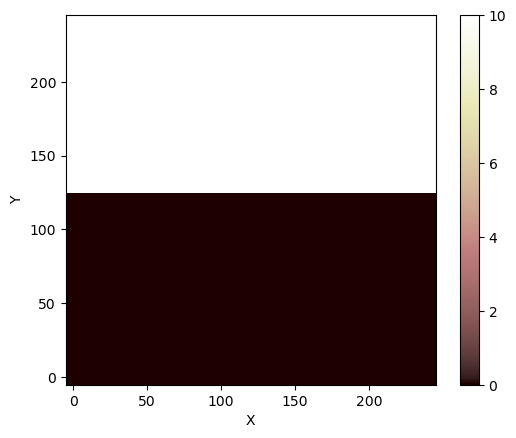

In [61]:
# now display the landscape
imshow_grid(new_grid, "topographic__elevation")

As in part <b>(d) (Sediment diffusion)</b>, let's close the left and right grid boundaries.

In [62]:
# close left and right boundaries
new_grid.set_closed_boundaries_at_grid_edges(True, False, True, False)

Great, we're back where we started with a recently faulted, un-diffused landscape. But now, rather than building our own diffusion model from scratch, we'll let Landlab's `LinearDiffuser` component do the work for us. Create an instance of this component named `diffusion_model` and pass your grid to the component.

In [63]:
# instantiate the linear diffuser component here
diffusion_model = LinearDiffuser(new_grid)

Great, we now have an instance of our model. Next, use the `run_one_step` method with a timestep `dt` on `diffusion_model` in a `for` loop in order to evolve our faulted landscape. As in part <b>(d) (Sediment diffusion)</b>, run the loop for 25 steps. Use the same timestep, `dt`, as defined above. 

In [64]:
# create your for loop here
# hint: you only need two lines of code in this cell to run the model

In [65]:
for _ in range(25):
    diffusion_model.run_one_step(dt)

<details>
    <summary><span style="color: beige; font-weight: bold;">Click for a solution</span></summary>

```python

# create your for loop here
# hint: you only need two lines of code in this cell to run the model
for _ in range(25):
    diffusion_model.run_one_step(dt)
```

</details>


Great, now visualize your landscape to see if it looks similar to the 5-line model you created in part <b>(d) (Sediment diffusion).

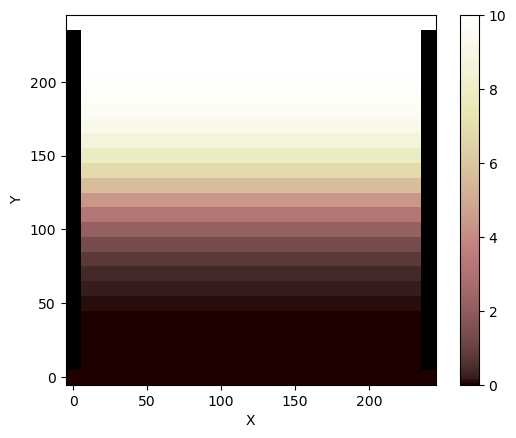

In [66]:
# visualize landscape
imshow_grid(new_grid, "topographic__elevation")

Fantastic! Your final output should look very simialr to the diffusion model you created in part <b>(d) (Sediment diffusion)</b>, but here you can see that using a Landlab component to simulate the diffusion process has simplified your `for` loop even further. You can appreciate how valuable this simplicity is, especially if you wanted to couple several components together (for example, flow routing, fluvial erosion, and hillslope diffusion) in order to evolve a more complex landscape.

As a final, fun exercise, check out the `LinearDiffuser` documentation using `?` once again. See if you can find the list of input parameters. These are listed in the order of the arguments taken by the component; the first one will always be `grid`. 

In [67]:
# check out the optional variables
?LinearDiffuser

- What is the name of this first optional argument? It is listed right after `grid`. Optional arguments have default values, which means the user does not need to specify its value. The user can, however, change the value if desired.
- What is its default value?
- Modify your existing instance of `LinearDiffuser` to include a different value for the first optional argument. 
> Hint: go back to the cell with the comment "instantiate the linear diffuser component here," and work from there
- Re-run the `for` loop to evolve the landscape, visualize the output, and note how changing the value of this optional argument impacts the form of the evolved landscape.

Congratulations on making it to the end of this tutorial!

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>